### Import libs

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten

%matplotlib inline
print(tf.__version__)

2.0.0


### Model Params

In [2]:
# Image height & width
img_height = 224
img_width = 224
img_depth = 3

IMG_SHAPE = (img_height, img_width, img_depth)


# initialize learning rate, batch size, and number of epochs
INIT_LR =  0.01
BATCH_SIZE = 16
NUM_EPOCHS = 4

# initialize the label names
labelNames = ["Cat", "Dog",'Panda']

### Import Data

In [3]:
# Set data directory to where image classes are
data_dir = '../datasets/animals'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
#     shuffle=True,
    class_mode='binary',
    subset='validation') # set as validation data

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


### Create model

import resnet50 model from keras

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
# load resnet model with imagenet weights
# do not include avg pool layer & output dense layer
incept = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [7]:
# summarize the model
incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
# freeze weights for downloaded conv layers
incept.trainable = False

In [9]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
# for layer in res_net50.layers[:5]:
#     layer.trainable = False

In [10]:
flatten = Flatten()

global_average_layer = GlobalAveragePooling2D()

dense1 = Dense(1024, activation='relu')
dense2 = Dense(1024, activation='relu')
output_layer = Dense(3, activation='softmax')




In [11]:
model = tf.keras.Sequential([
  incept,
  global_average_layer,
#   flatten,
  dense1,
#   dense2,
  output_layer])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 2,101,251
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
# initialize the optimizer and compile the model
print("[INFO] Initialize optimizer")
opt = SGD(lr=INIT_LR,
          momentum=0.9,
          decay=INIT_LR / NUM_EPOCHS)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])
 

[INFO] Initialize optimizer


In [14]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = NUM_EPOCHS, 
    verbose=1)

Epoch 1/4
150/150 [==============================] - 47s 313ms/step - loss: 0.3921 - accuracy: 0.8458 - val_loss: 0.1712 - val_accuracy: 0.9392
Epoch 2/4
150/150 [==============================] - 44s 291ms/step - loss: 0.2348 - accuracy: 0.9137 - val_loss: 0.0649 - val_accuracy: 0.9730
Epoch 3/4
150/150 [==============================] - 44s 292ms/step - loss: 0.1956 - accuracy: 0.9242 - val_loss: 0.0357 - val_accuracy: 0.9848
Epoch 4/4
150/150 [==============================] - 44s 292ms/step - loss: 0.1541 - accuracy: 0.9404 - val_loss: 0.0753 - val_accuracy: 0.9730


### Evaluate

In [15]:
test_data_dir = '../datasets/test_animals'

testdatagen = ImageDataGenerator(rescale=1./255)

test_generator = testdatagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size= 32,
        class_mode='binary')

Found 9 images belonging to 3 classes.


In [16]:
testX, testY = test_generator[0]

In [17]:
testX.shape

(9, 224, 224, 3)

In [18]:
from sklearn.metrics import classification_report

In [19]:
# evaluate the model accuracy on new data
predictions = model.predict(testX, batch_size=BATCH_SIZE)

In [20]:
print(predictions.argmax(axis=1))
print(testY)

[0 2 0 2 1 1 1 0 2]
[0. 2. 0. 2. 1. 1. 1. 0. 2.]


In [21]:
print(classification_report(testY, predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00         3
         Dog       1.00      1.00      1.00         3
       Panda       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testY, predictions.argmax(axis=1))

In [23]:
cm

array([[3, 0, 0],
       [0, 3, 0],
       [0, 0, 3]], dtype=int64)

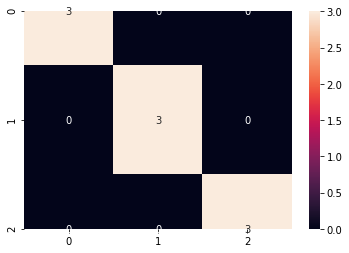

In [24]:
# plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True)

In [25]:
preds = predictions.argmax(axis=1)

In [26]:
testY = testY.astype(int)

In [27]:
print(preds)
print(testY)

[0 2 0 2 1 1 1 0 2]
[0 2 0 2 1 1 1 0 2]


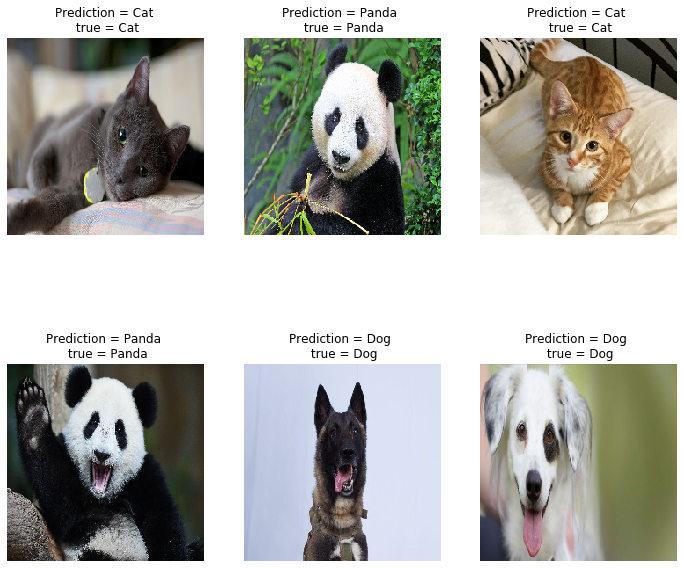

In [28]:
L = 2
W = 3

fig, axes = plt.subplots(L,W,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(testX[i])
    axes[i].set_title('Prediction = {} \n true = {}'.format(labelNames[preds[i]]
                                                        ,labelNames[testY[i]]))
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0)